# Graph AutoEncoder with StellarGraph

In [1]:
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from stellargraph import datasets

2024-04-14 20:51:03.017370: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-14 20:51:03.017425: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-14 20:51:05.405762: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-14 20:51:05.406097: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-14 20:51:05.406114: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-14 20:51:05.406137: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running 

In [2]:
dataset = datasets.Cora()
G, _ = dataset.load()

In [3]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [4]:
edge_splitter_test = EdgeSplitter(G)

G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

edge_splitter_train = EdgeSplitter(G_test)

G_train, edge_ids_train, edge_labels_train = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 542 positive and 542 negative edges. **
** Sampled 542 positive and 542 negative edges. **


In [5]:
train_gen = FullBatchLinkGenerator(G, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [6]:
test_gen = FullBatchLinkGenerator(G, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [7]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [8]:
x_inp, x_out = gcn.in_out_tensors()

In [9]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [10]:
prediction = keras.layers.Reshape((-1,))(prediction)


In [11]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 2708, 1433)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(1, None, 2)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(1, None)]          0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (1, 2708, 1433)      0           input_1[0][0]                    
______________________________________________________________________________________________

In [13]:
history = model.fit(train_flow, validation_data=test_flow, epochs=50)

Epoch 1/50


2024-04-14 20:51:09.165646: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-04-14 20:51:09.167036: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199990000 Hz


1/1 [==============================] - 3s 3s/step - loss: 1.7554 - binary_accuracy: 0.5000 - val_loss: 0.8120 - val_binary_accuracy: 0.6827
Epoch 2/50
1/1 [==============================] - 0s 164ms/step - loss: 1.0576 - binary_accuracy: 0.6531 - val_loss: 0.6350 - val_binary_accuracy: 0.7149
Epoch 3/50
1/1 [==============================] - 0s 153ms/step - loss: 0.7307 - binary_accuracy: 0.7002 - val_loss: 0.5587 - val_binary_accuracy: 0.7269
Epoch 4/50
1/1 [==============================] - 0s 158ms/step - loss: 0.6061 - binary_accuracy: 0.7399 - val_loss: 0.5700 - val_binary_accuracy: 0.6827
Epoch 5/50
1/1 [==============================] - 0s 176ms/step - loss: 0.5755 - binary_accuracy: 0.7251 - val_loss: 0.5588 - val_binary_accuracy: 0.6919
Epoch 6/50
1/1 [==============================] - 0s 163ms/step - loss: 0.5843 - binary_accuracy: 0.7315 - val_loss: 0.5381 - val_binary_accuracy: 0.7149
Epoch 7/50
1/1 [==============================] - 0s 195ms/step - loss: 0.5433 - binary_ac

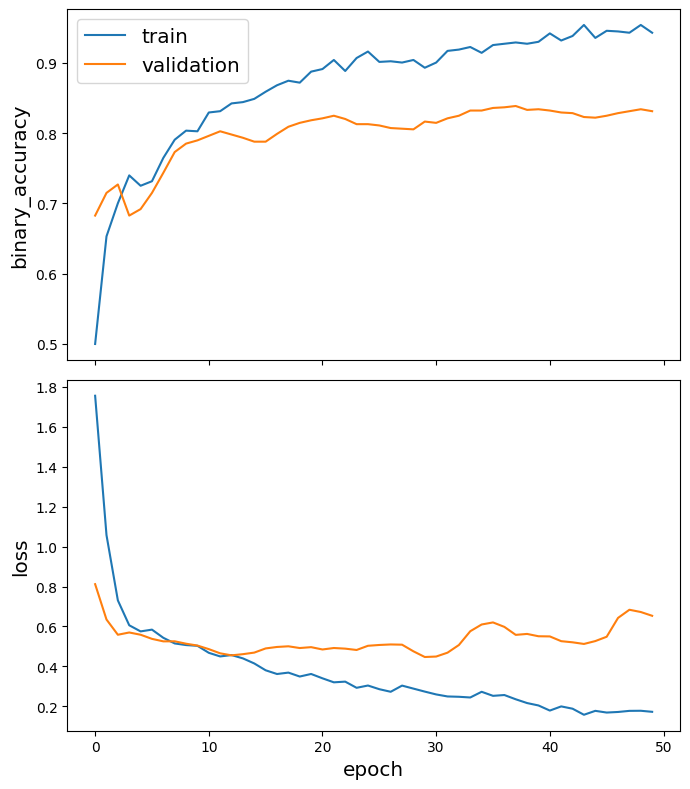

In [14]:
from stellargraph.utils import plot_history

plot_history(history)